# Dados e Aprendizagem Automática
### Part VIII

## **Multi Layer Percepreton using Titanic Dataset - IV**

#### Imports, installations and settings

In [1]:
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from IPython.display import display

from livelossplot import PlotLosses

from torchinfo import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear, Sigmoid, ReLU, Softmax, Module
from torch.optim import SGD, Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.nn.init import xavier_uniform_, kaiming_uniform_

%matplotlib inline

device = torch.device("cpu")

#### Data Preparation

In [7]:
class CSVDataset():
    def __init__(self):

        df_X = pd.read_csv("titanic_X_scaled.csv", header=0)
        df_y = pd.read_csv("titanic_y_scaled.csv", header=0)

        self.X = df_X.values
        self.y = df_y.values[:, 0]-1

        self.X = self.X.astype('float32')
        self.y = torch.tensor(self.y, dtype=torch.long, device=device)
        
    def __len__(self):
        return len(self.X)
 
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    def get_splits(self, n_test):
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        return random_split(self, [train_size, test_size])
    
def prepare_data(n_test):
    dataset = CSVDataset()
    train, test = dataset.get_splits(n_test)
    train_dl = DataLoader(train, batch_size=len(train), shuffle=True)
    test_dl = DataLoader(test, batch_size=len(train), shuffle=True)
    return train_dl, test_dl

In [8]:
train_dl, test_dl = prepare_data(0.33)

#### MLP Model 4

In [20]:
EPOCHS = 250
LEARNING_RATE = 0.005

In [9]:
class MLP_4(Module):
    def __init__(self, n_inputs):
        super(MLP_4, self).__init__()
        self.hidden1 = Linear(n_inputs, 32)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.hidden2 = Linear(32, 40)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.hidden3 = Linear(40, 32)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        self.hidden4 = Linear(32, 16)
        kaiming_uniform_(self.hidden4.weight, nonlinearity='relu')
        self.act4 = ReLU()
        self.hidden5 = Linear(16, 8)
        kaiming_uniform_(self.hidden5.weight, nonlinearity='relu')
        self.act5 = ReLU()
        self.hidden6 = Linear(8, 3)
        xavier_uniform_(self.hidden6.weight)
        self.act6 = Softmax(dim=1)
 
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        X = self.hidden4(X)
        X = self.act4(X)
        X = self.hidden5(X)
        X = self.act5(X)
        X = self.hidden6(X)
        X = self.act6(X)
        return X

Define the neural network

In [10]:
model = MLP_4(8)

Visualize the network

In [11]:
print(summary(model, input_size=(len(train_dl.dataset), 8), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP_4                                    [597, 3]                  --
├─Linear: 1-1                            [597, 32]                 288
├─ReLU: 1-2                              [597, 32]                 --
├─Linear: 1-3                            [597, 40]                 1,320
├─ReLU: 1-4                              [597, 40]                 --
├─Linear: 1-5                            [597, 32]                 1,312
├─ReLU: 1-6                              [597, 32]                 --
├─Linear: 1-7                            [597, 16]                 528
├─ReLU: 1-8                              [597, 16]                 --
├─Linear: 1-9                            [597, 8]                  136
├─ReLU: 1-10                             [597, 8]                  --
├─Linear: 1-11                           [597, 3]                  27
├─Softmax: 1-12                          [597, 3]                  --
Total 

MLP_4(
  (hidden1): Linear(in_features=8, out_features=32, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=32, out_features=40, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=40, out_features=32, bias=True)
  (act3): ReLU()
  (hidden4): Linear(in_features=32, out_features=16, bias=True)
  (act4): ReLU()
  (hidden5): Linear(in_features=16, out_features=8, bias=True)
  (act5): ReLU()
  (hidden6): Linear(in_features=8, out_features=3, bias=True)
  (act6): Softmax(dim=1)
)

### Model 4 settings: Epochs=, LR=, Softmax-6, CEL, Adam

#### Train the model

In [19]:
EPOCHS = 250
LEARNING_RATE = 0.005

In [20]:
def train_model(train_dl, test_dl, model):
    liveloss = PlotLosses()

    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    
    for epoch in range(EPOCHS):
        logs = {}
        model.train()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()

        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in test_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            running_loss += loss.detach() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(test_dl.dataset)
        epoch_acc = running_corrects.float() / len(test_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()

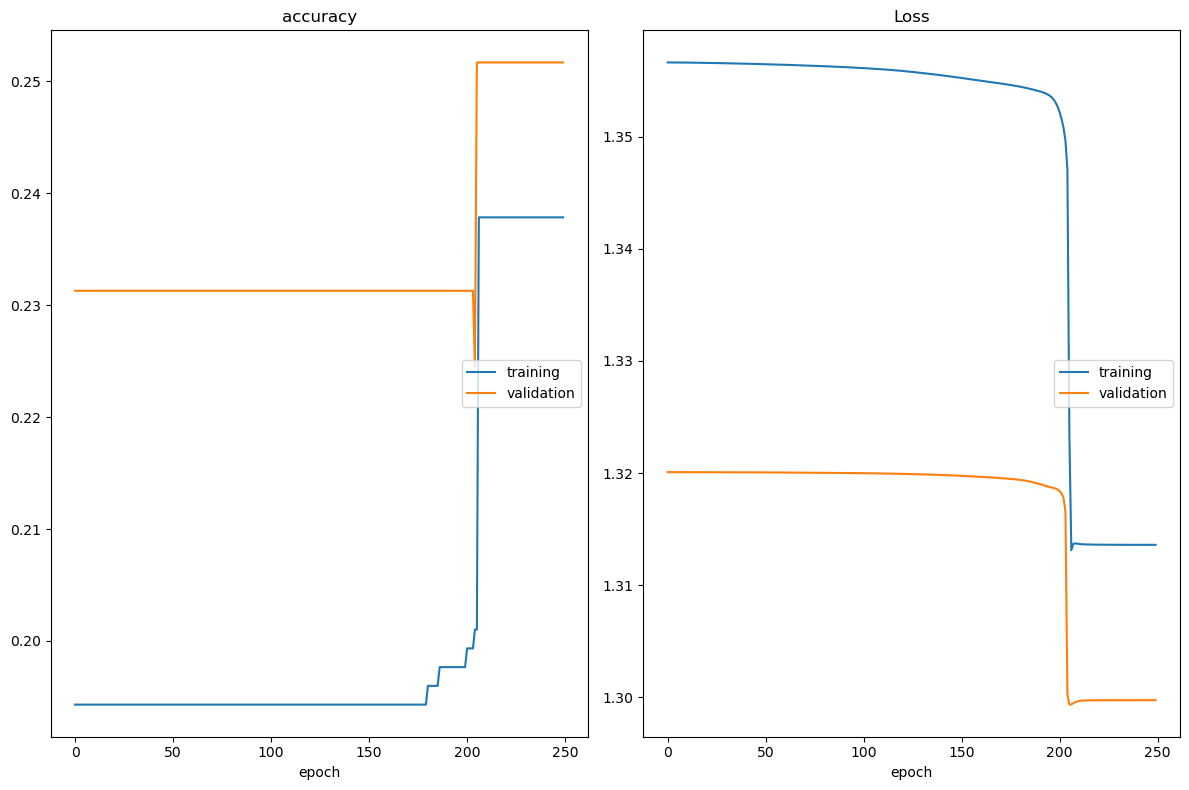

accuracy
	training         	 (min:    0.194, max:    0.238, cur:    0.238)
	validation       	 (min:    0.224, max:    0.252, cur:    0.252)
Loss
	training         	 (min:    1.313, max:    1.357, cur:    1.314)
	validation       	 (min:    1.299, max:    1.320, cur:    1.300)


In [21]:
train_model(train_dl, test_dl, model)

#### Evaluate the model

In [22]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return predictions, actual_values

In [23]:
def display_confusion_matrix(cm):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=['Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 1', 'Class 2', 'Class 3'], annot_kws={"size": 12}, fmt='g', linewidths=.5)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

In [24]:
predictions, actual_values = evaluate_model(test_dl, model)

In [25]:
success = 0
failure = 0
for r,p in zip(actual_values, predictions):
    if r==p: success+=1  
    else: failure+=1

In [26]:
acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'success:{success} failure:{failure}')

Accuracy: 0.252

success:74 failure:220


In [27]:
print(classification_report(actual_values, predictions))

              precision    recall  f1-score   support

           0       0.25      1.00      0.40        74
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00       152

    accuracy                           0.25       294
   macro avg       0.08      0.33      0.13       294
weighted avg       0.06      0.25      0.10       294



C:\Users\al76413\AppData\Local\miniconda3\envs\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\al76413\AppData\Local\miniconda3\envs\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\al76413\AppData\Local\miniconda3\envs\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier